# Alt Architecture - More Subfeatures! Now we introduce them! Lower loss!

Breaking down each digit into it's out subfeature, and using that to build back up!

## Imports

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, load_intermediate_labels

## Set Device to GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [3]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [4]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Loading Subfeatures

In [5]:
min_sub_feature_dict = load_intermediate_labels("min_sub_feature_dict_v1.pkl")
sub_feature_dict = load_intermediate_labels("sub_feature_dict_v1.pkl")

# Our Test

## Architecture

We keep our two hidden layers at image size to be able to calculate a local loss to push those layers to learn human recognizable structures. However, for the example below, we don't calculate intermediate loss, as we need a basis.

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        layer_size_by_pixels = 28 * 28
        
        self.first_layer = nn.ModuleList([nn.Linear(layer_size_by_pixels, layer_size_by_pixels) for _ in range(4)])
        self.second_layer = nn.ModuleList([nn.Linear(layer_size_by_pixels, layer_size_by_pixels) for _ in range(2)])
        self.classification_layer = nn.Linear(layer_size_by_pixels, 10)
        self.activation_function = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        first_layer_outputs = []
        for layer in self.first_layer:
            out = layer(x)
            act = self.activation_function(out)
            first_layer_outputs.append(act)
        
        second_layer_outputs = []
        for i in range(2):
            combined_input = first_layer_outputs[2*i] + first_layer_outputs[2*i + 1]
            out = self.second_layer[i](combined_input)
            act = self.activation_function(out)
            second_layer_outputs.append(act)
        
        # Combine second_layer_outputs for classification
        combined_act = sum(second_layer_outputs)
        
        classification_out = self.classification_layer(combined_act)
        
        # Return classification_out and all activations
        return classification_out, first_layer_outputs, second_layer_outputs

In [7]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [8]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()
sub_feature_loss_fn = nn.MSELoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [9]:
print(f"Model weights (to compare below): {model.first_layer[0].weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]


### Verify Reproducibility

In [10]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.first_layer[0].weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.first_layer[0].weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [11]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx].copy()).float(),
            torch.tensor(self.labels[idx].copy(), dtype=torch.long),
        )

In [12]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [13]:
# training data
train_dataset = EdgeDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

## Training Loop

In [14]:
num_epochs = 20
best_val_loss = float('inf')
loss_factor = 0.001
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    train_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # Get subfeature labels from dictionaries based on digit labels
        batch_size = labels.size(0)
        
        first_layer_labels = []
        second_layer_labels = []

        for digit in min_sub_feature_dict:
            min_sub_feature_dict[digit] = [
                torch.tensor(subfeature, dtype=torch.float32) if isinstance(subfeature, np.ndarray)
                else subfeature
                for subfeature in min_sub_feature_dict[digit]
            ]
        
        for digit in sub_feature_dict:
            sub_feature_dict[digit] = [
                torch.tensor(subfeature, dtype=torch.float32) if isinstance(subfeature, np.ndarray)
                else subfeature
                for subfeature in sub_feature_dict[digit]
            ]
            
        # For each sample in the batch, map digit to its subfeatures
        for digit in labels:
            min_subfeatures = min_sub_feature_dict[digit.item()]
            first_layer_labels.extend(min_subfeatures)
            
            subfeatures = sub_feature_dict[digit.item()]
            second_layer_labels.extend(subfeatures)

        first_layer_labels = torch.stack(first_layer_labels).to(device)
        second_layer_labels = torch.stack(second_layer_labels).to(device)

        first_layer_labels = first_layer_labels.view(batch_size, 4, 784)
        second_layer_labels = second_layer_labels.view(batch_size, 2, 784)
        
        # forward pass
        classification_out, first_layer_outputs, second_layer_outputs = model(images)
        
        # --- Loss and Backprop ---

        # clear gradients
        optimizer.zero_grad()

        # subfeature loss
        first_loss = sum(sub_feature_loss_fn(out, first_layer_labels[:, i, :]) for i, out in enumerate(first_layer_outputs))
        second_loss = sum(sub_feature_loss_fn(out, second_layer_labels[:, i, :]) for i, out in enumerate(second_layer_outputs))

        # classification loss
        classification_loss = classification_loss_fn(classification_out, labels)

        # total loss
        total_loss = loss_factor * (first_loss + second_loss) + classification_loss
        total_loss.backward()
        
        optimizer.step()

        # update progress
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=classification_loss.item())

    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels  = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

Epoch 1/20
  Train Loss: 7.7205
  Val Loss: 0.7277 | Val Acc: 92.44%


Epoch 2/20
  Train Loss: 4.8707
  Val Loss: 0.5624 | Val Acc: 95.35%


Epoch 3/20
  Train Loss: 4.4517
  Val Loss: 0.5696 | Val Acc: 96.02%


Epoch 4/20
  Train Loss: 4.1156
  Val Loss: 1.0073 | Val Acc: 93.12%


Epoch 5/20
  Train Loss: 4.0629
  Val Loss: 0.8824 | Val Acc: 94.80%


Epoch 6/20
  Train Loss: 3.8549
  Val Loss: 0.9698 | Val Acc: 96.03%


Epoch 7/20
  Train Loss: 3.7782
  Val Loss: 0.9612 | Val Acc: 95.92%


Epoch 8/20
  Train Loss: 3.7117
  Val Loss: 1.0465 | Val Acc: 95.70%


Epoch 9/20
  Train Loss: 3.6372
  Val Loss: 1.0323 | Val Acc: 96.52%


Epoch 10/20
  Train Loss: 3.6271
  Val Loss: 1.4025 | Val Acc: 95.78%


Epoch 11/20
  Train Loss: 3.6019
  Val Loss: 1.2128 | Val Acc: 96.12%


Epoch 12/20
  Train Loss: 3.5938
  Val Loss: 1.2779 | Val Acc: 96.06%


Epoch 13/20
  Train Loss: 3.5830
  Val Loss: 1.2197 | Val Acc: 96.85%


Epoch 14/20
  Train Loss: 3.6217
  Val Loss: 1.5201 | Val Acc: 96.36%


Epoch 15/20
  Train Loss: 3.5930
  Val Loss: 1.5250 | Val Acc: 96.34%


Epoch 16/20
  Train Loss: 3.5151
  Val Loss: 1.9336 | Val Acc: 95.81%


Epoch 17/20
  Train Loss: 3.7592
  Val Loss: 1.9260 | Val Acc: 96.50%


Epoch 18/20
  Train Loss: 3.7662
  Val Loss: 1.9342 | Val Acc: 96.24%


Epoch 19/20
  Train Loss: 3.7179
  Val Loss: 2.2158 | Val Acc: 96.62%


Epoch 20/20
  Train Loss: 3.7621
  Val Loss: 2.7856 | Val Acc: 95.70%


## Eval

In [15]:
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for batch in test_bar:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, _, _ = model(images)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 463.03it/s]

Final Test Accuracy: 95.68%


# Exploring the Resulting Model

## Visualizing Weights

In [ ]:
classification_w = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
vertical_w = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
horizontal_w = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

fig, axes = plt.subplots(1, 3, figsize=(9, 5))

visualize_image(horizontal_w, "Horizontal Layer Weights", ax=axes[0])
visualize_image(vertical_w, "Vertical Layer Weights", ax=axes[1])
visualize_image(classification_w, "Classification Layer Weights", ax=axes[2])

plt.tight_layout()
plt.show()

# Visualizing Activations

In [16]:
model.eval()
eval_examples = list()
with torch.no_grad():
    for idx, img in enumerate(test_images[:10]):
        img_tensor = torch.from_numpy(img.copy()).float().unsqueeze(0).unsqueeze(0).to('cuda')
        out, first_act_layer, second_act_layer = model(img_tensor)
        
        first_act_imgs  = [act.clone().reshape(28, 28).detach().cpu().numpy() for act in first_act_layer]
        second_act_imgs = [act.clone().reshape(28, 28).detach().cpu().numpy() for act in second_act_layer]

        label = test_labels[idx]
        eval_examples.append((label, img, out, first_act_imgs, second_act_imgs))

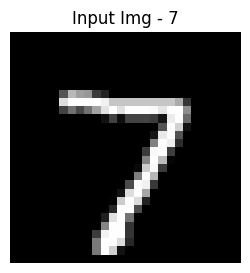

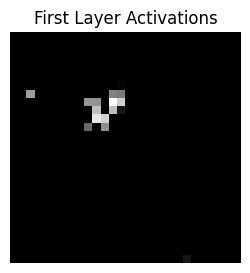

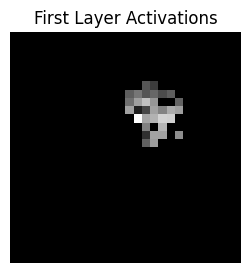

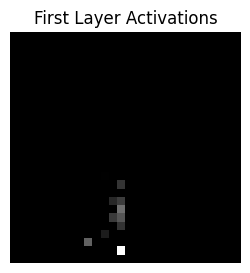

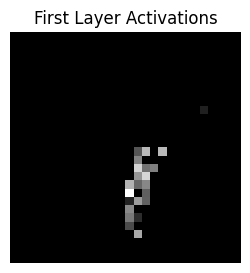

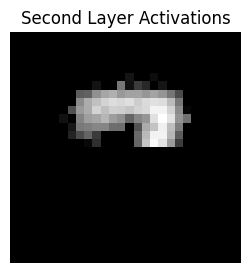

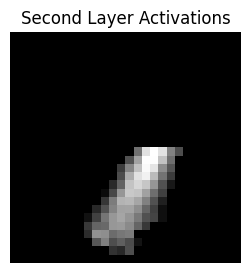

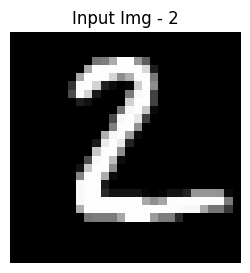

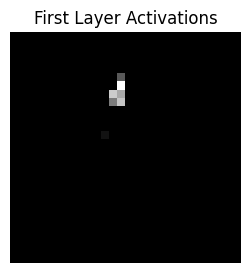

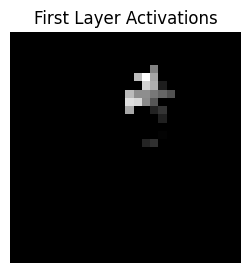

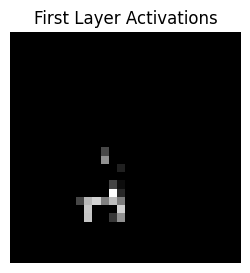

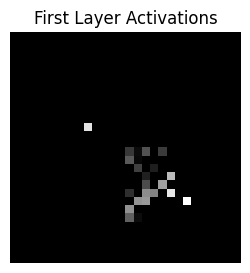

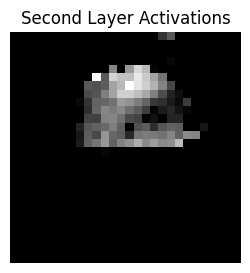

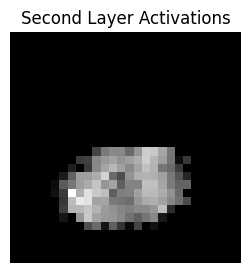

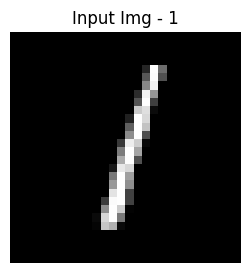

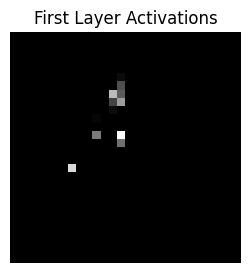

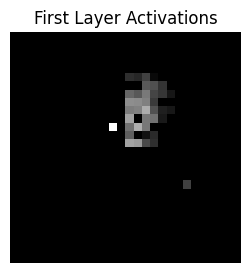

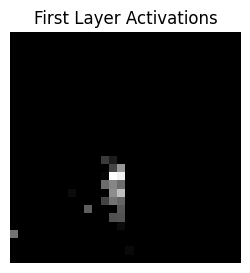

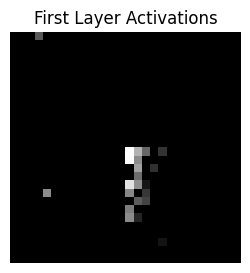

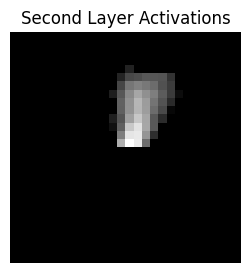

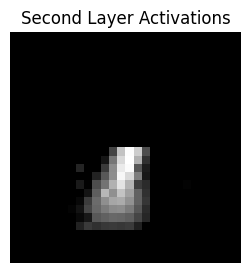

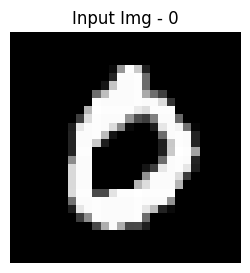

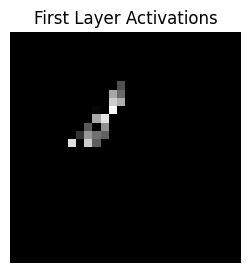

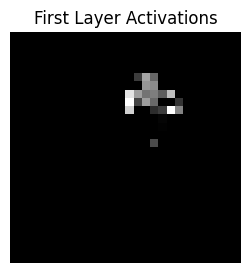

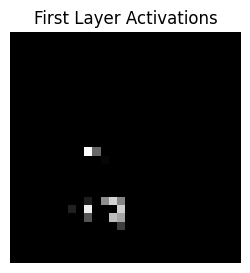

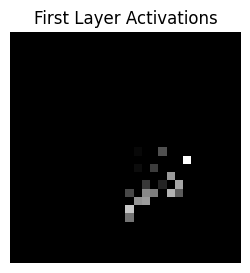

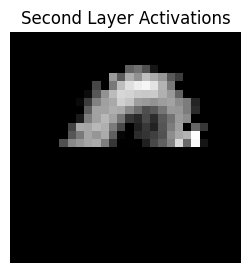

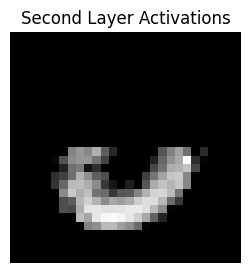

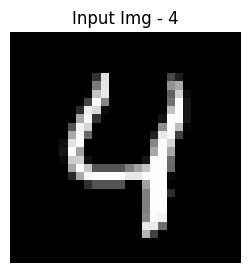

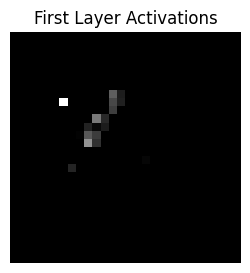

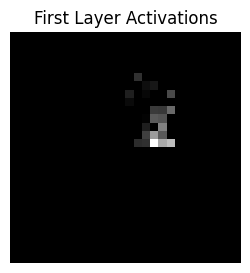

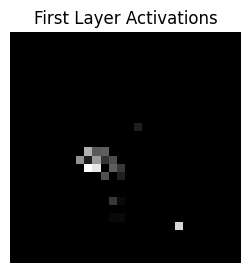

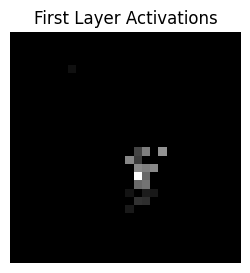

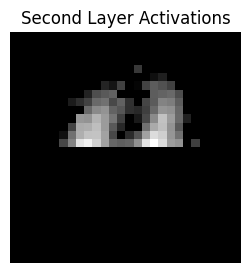

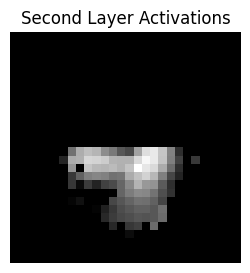

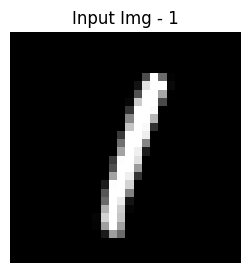

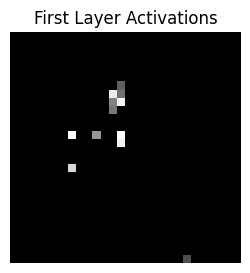

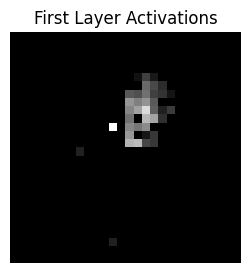

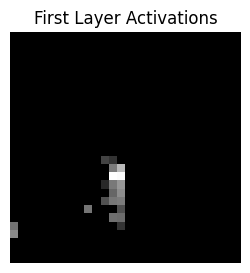

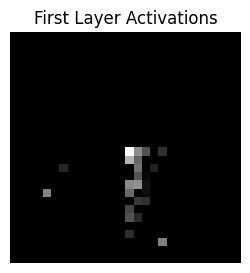

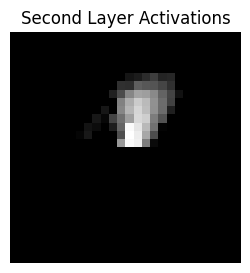

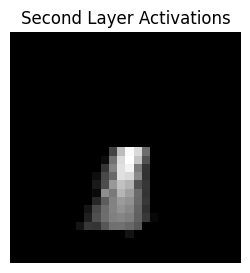

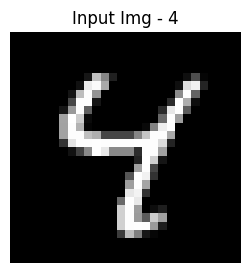

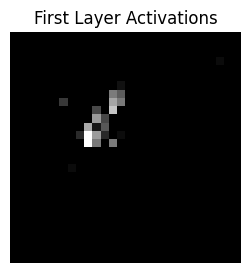

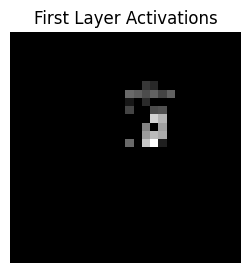

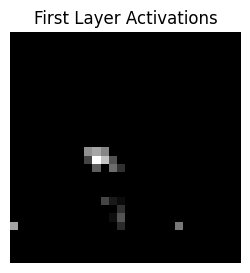

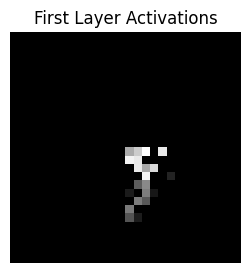

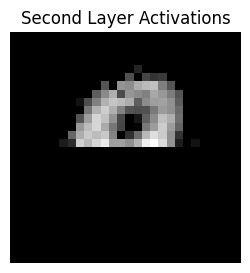

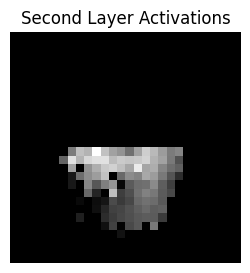

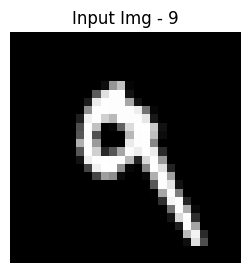

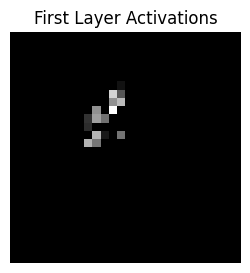

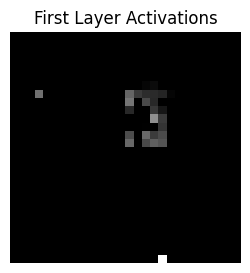

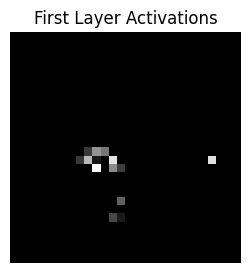

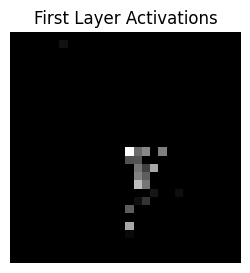

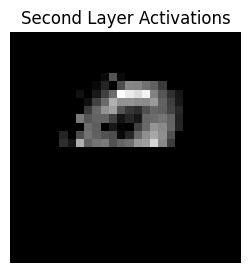

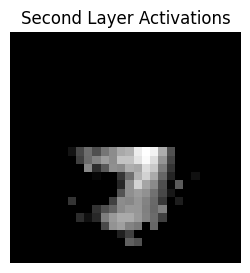

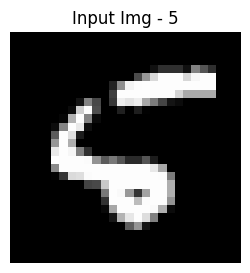

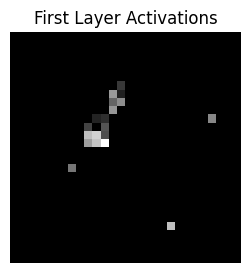

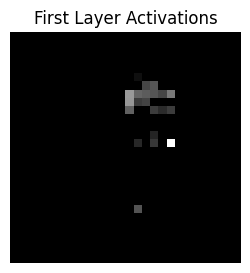

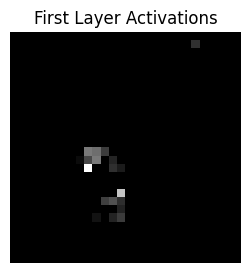

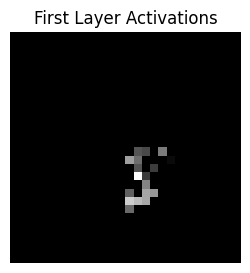

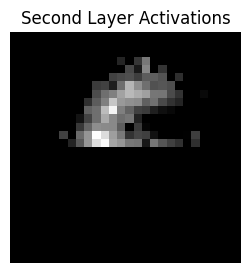

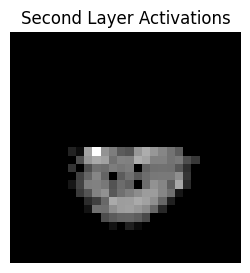

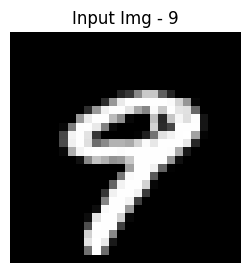

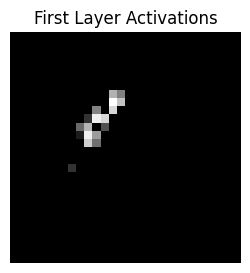

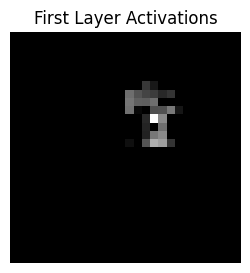

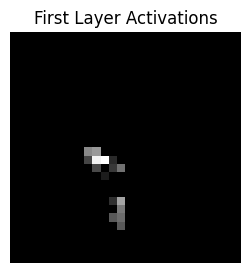

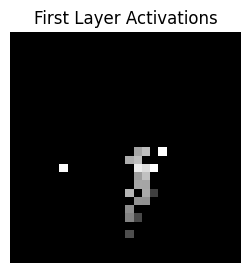

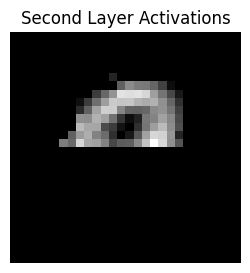

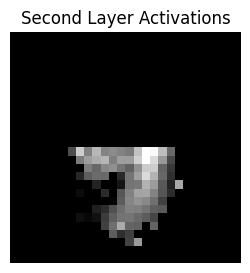

In [17]:
x_values = list(range(0, 10))
for label, img, out, first_act_imgs, second_act_imgs in eval_examples:
    inference = torch.max(out, 1)[1].item()

    visualize_image(img, f"Input Img - {label}")
    for img in first_act_imgs:
        visualize_image(img, "First Layer Activations")

    for img in second_act_imgs:
        visualize_image(img, "Second Layer Activations")

# Different Inputs

## Horizontal Edges

In [ ]:
model.eval()
h_edge_inputs = list()
with torch.no_grad():
    for idx, img in enumerate(test_horizontal_image_labels[:10]):
        img_tensor = torch.from_numpy(img.copy().reshape(28, 28)).float().unsqueeze(0).unsqueeze(0).to('cuda')
        out, v_act, h_act = model(img_tensor)
        
        v_act_img = v_act.clone().reshape(28, 28).detach().cpu().numpy()
        h_act_img = h_act.clone().reshape(28, 28).detach().cpu().numpy()

        label = test_labels[idx]
        h_edge_inputs.append((label, img.copy().reshape(28, 28), out, v_act_img, h_act_img))

In [ ]:
x_values = list(range(0, 10))
for label, img, out, v_act_img, h_act_img in h_edge_inputs:
    inference = torch.max(out, 1)[1].item()
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    visualize_image(img, f"Input Img - {label}", ax=axes[0])
    visualize_image(h_act_img, "Horizontal Activations", ax=axes[1])
    visualize_image(v_act_img, "Vertical Activations", ax=axes[2])

    ax3 = plt.subplot(1, 4, 4)
    bars3 = ax3.bar(x_values, out.tolist()[0])
    ax3.set_xticks(x_values)
    ax3.set_title(f"Activation max: {inference}")
    
    plt.tight_layout()
    plt.show()

In [ ]:
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in test_loader:
        images, labels, horizontal_labels, vertical_labels = batch
        images, labels, horizontal_labels, vertical_labels = images.to(device), labels.to(device), horizontal_labels.to(device), vertical_labels.to(device)
        if len(horizontal_labels) == 128:
            h_imgs = horizontal_labels.reshape(128, 28, 28)
        else:
            h_imgs = horizontal_labels.reshape(16, 28, 28)
        
        # forward pass
        classification_out, _, _ = model(h_imgs)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

## Vertical Edges

In [ ]:
model.eval()
v_edge_inputs = list()
with torch.no_grad():
    for idx, img in enumerate(test_vertical_image_labels[:10]):
        img_tensor = torch.from_numpy(img.copy().reshape(28, 28)).float().unsqueeze(0).unsqueeze(0).to('cuda')
        out, v_act, h_act = model(img_tensor)
        
        v_act_img = v_act.clone().reshape(28, 28).detach().cpu().numpy()
        h_act_img = h_act.clone().reshape(28, 28).detach().cpu().numpy()

        label = test_labels[idx]
        v_edge_inputs.append((label, img.copy().reshape(28, 28), out, v_act_img, h_act_img))

In [ ]:
x_values = list(range(0, 10))
for label, img, out, v_act_img, h_act_img in v_edge_inputs:
    inference = torch.max(out, 1)[1].item()
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    visualize_image(img, f"Input Img - {label}", ax=axes[0])
    visualize_image(h_act_img, "Horizontal Activations", ax=axes[1])
    visualize_image(v_act_img, "Vertical Activations", ax=axes[2])

    ax3 = plt.subplot(1, 4, 4)
    bars3 = ax3.bar(x_values, out.tolist()[0])
    ax3.set_xticks(x_values)
    ax3.set_title(f"Activation max: {inference}")
    
    plt.tight_layout()
    plt.show()

In [ ]:
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in test_loader:
        images, labels, horizontal_labels, vertical_labels = batch
        images, labels, horizontal_labels, vertical_labels = images.to(device), labels.to(device), horizontal_labels.to(device), vertical_labels.to(device)
        if len(horizontal_labels) == 128:
            v_imgs = vertical_labels.reshape(128, 28, 28)
        else:
            v_imgs = vertical_labels.reshape(16, 28, 28)
        
        # forward pass
        classification_out, _, _ = model(v_imgs)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

There might be something to vertical edges being more important features than horizontal features.

## Random Inputs

In [ ]:
height, width = 28, 28
noisy_images = [np.random.randint(0, 256, (height, width), dtype=np.uint8) for _ in range(0, 10000)]

In [ ]:
len(noisy_images)

In [ ]:
visualize_image(noisy_images[0], "Noise")

In [ ]:
model.eval()
noisy_inputs = list()
with torch.no_grad():
    for img in noisy_images[:10]:
        img_tensor = torch.from_numpy(img.copy().reshape(28, 28)).float().unsqueeze(0).unsqueeze(0).to('cuda')
        out, v_act, h_act = model(img_tensor)
        
        v_act_img = v_act.clone().reshape(28, 28).detach().cpu().numpy()
        h_act_img = h_act.clone().reshape(28, 28).detach().cpu().numpy()

        label = "Noise"
        noisy_inputs.append((label, img, out, v_act_img, h_act_img))

In [ ]:
x_values = list(range(0, 10))
for label, img, out, v_act_img, h_act_img in noisy_inputs:
    inference = torch.max(out, 1)[1].item()
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    visualize_image(img, f"Input Img - {label}", ax=axes[0])
    visualize_image(h_act_img, "Horizontal Activations", ax=axes[1])
    visualize_image(v_act_img, "Vertical Activations", ax=axes[2])

    ax3 = plt.subplot(1, 4, 4)
    bars3 = ax3.bar(x_values, out.tolist()[0])
    ax3.set_xticks(x_values)
    ax3.set_title(f"Activation max: {inference}")
    
    plt.tight_layout()
    plt.show()

In [ ]:
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

answer_dict = {}
activation_dict = {}
with torch.no_grad():
    for img in noisy_images:
        img_tensor = torch.from_numpy(img.copy().reshape(28, 28)).float().unsqueeze(0).unsqueeze(0).to('cuda')

        # forward pass
        classification_out, _, _ = model(img_tensor)

        # stats
        _, predicted = torch.max(classification_out, 1)

        for i, act in enumerate(classification_out[0]):
            if i in activation_dict:
                activation_dict[i] += act.item()
            else:
                activation_dict[i] = act.item()

        if predicted.item() in answer_dict:
            answer_dict[predicted.item()] += 1
        else:
            answer_dict[predicted.item()] = 1
        
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

In [ ]:
answer_dict

In [ ]:
sorted([(key, round(value, 2)) for key, value in activation_dict.items()], key=lambda x: x[1], reverse=True)

Honestly, not a terrible distribution, but it seems our low loss factor is "best" in this regard.

In [ ]:
activation_dict

In [ ]:
categories = [str(x) for x in range(0, 10)]
x = np.array([int(k) for k in activation_dict.keys()])  # positions for the categories
y = np.array([int(v) for v in activation_dict.values()])

fig, ax = plt.subplots()

# Plotting the first set of bars
bars1 = ax.bar(x, y)

# Adding labels and title
ax.set_xlabel('Digit Classes')
ax.set_ylabel('Summed Activations')
ax.set_title('Summed Activations vs. Digit Class')
ax.set_xticks(x)
ax.set_xticklabels(categories)

plt.show()